In [42]:
import torch.cuda
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict, concatenate_datasets
import evaluate
import numpy as np
import wandb
import seaborn as sns


with open('secrets/wandb_api_key.txt') as f:
    wandb.login(key=f.read())

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/marcus/.netrc


### Train pre-trained model from hugging face
#### Load Dataset

In [43]:
ds = Dataset.load_from_disk('data/code_search_net_relevance.hf')
ds

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text'],
    num_rows: 315
})

#### Convert groups to binary model

In [44]:
def convert_to_binary(data):
    if data['label'] in [2, 3]:
        data['label'] = 1
    return data

ds = ds.map(convert_to_binary)


#### Balance Dataset

In [45]:
# ds_0 = ds.filter(lambda data: data['label'] == 0)
# ds_1 = Dataset.from_dict(ds.filter(lambda data:data['label'] == 1)[:len(ds_0)])
# ds = concatenate_datasets([ds_0, ds_1])
# ds

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text'],
    num_rows: 266
})

#### Load tokenizer and preprocess

In [46]:
# PRETRAINED_MODEL = 'distilbert-base-uncased'
PRETRAINED_MODEL = 'microsoft/codebert-base'

In [47]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)

def preprocess(data):
    return tokenizer(data['text'], truncation=True, padding=True)

data_tokens = ds.map(preprocess)
data_tokens

Dataset({
    features: ['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens', 'label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 266
})

In [48]:
# TODO maybe equalize both classes
data_tokens = data_tokens.remove_columns(['func_code_string', 'func_code_tokens', 'func_documentation_string', 'func_documentation_tokens'])
data_tokens

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 266
})

<Axes: xlabel='label', ylabel='count'>

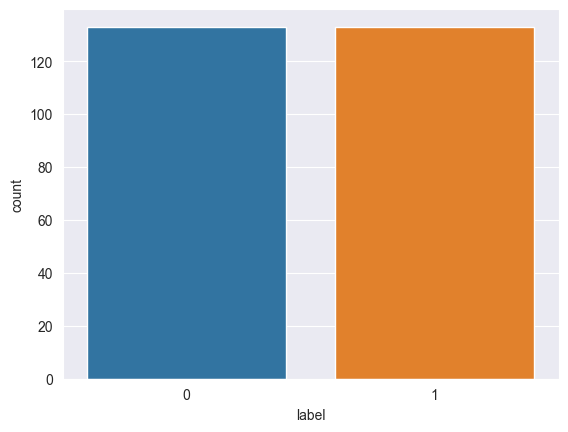

In [49]:
sns.countplot(data_tokens.to_pandas(), x='label')

In [50]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [51]:
tokenizer.decode(data_tokens['input_ids'][0])

'<s>Converts the given postgresql seconds to java seconds. Reverse engineered by inserting varying\ndates to postgresql and tuning the formula until the java dates matched. See {@link #toPgSecs}\nfor the reverse operation.\n\n@param secs Postgresql seconds.\n@return Java seconds.[SEP]private static long toJavaSecs(long secs) {\n    // postgres epoc to java epoc\n    secs += 946684800L;\n\n    // Julian/Gregorian calendar cutoff point\n    if (secs < -12219292800L) { // October 4, 1582 -> October 15, 1582\n      secs += 86400 * 10;\n      if (secs < -14825808000L) { // 1500-02-28 -> 1500-03-01\n        int extraLeaps = (int) ((secs + 14825808000L) / 3155760000L);\n        extraLeaps--;\n        extraLeaps -= extraLeaps / 4;\n        secs += extraLeaps * 86400L;\n      }\n    }\n    return secs;\n  }</s>'

#### Evaluate

In [52]:
f1 = evaluate.load('f1')
accuracy = evaluate.load('accuracy')
recall = evaluate.load('recall')
precision = evaluate.load('precision')

In [53]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy_res = accuracy.compute(predictions=predictions, references=labels)
    f1_macro_res = f1.compute(predictions=predictions, references=labels, average='macro')
    f1_micro_res = f1.compute(predictions=predictions, references=labels, average='micro')
    f1_weighted_res = f1.compute(predictions=predictions, references=labels, average='weighted')
    recall_macro_res = recall.compute(predictions=predictions, references=labels, average='macro')
    recall_micro_res = recall.compute(predictions=predictions, references=labels, average='micro')
    recall_weighted_res = recall.compute(predictions=predictions, references=labels, average='weighted')
    precision_macro_res = precision.compute(predictions=predictions, references=labels, average='macro')
    precision_micro_res = precision.compute(predictions=predictions, references=labels, average='micro')
    precision_weighted_res = precision.compute(predictions=predictions, references=labels, average='weighted')

    return {'accuracy': accuracy_res,
            'f1_macro': f1_macro_res, 'f1_micro': f1_micro_res, 'f1_weighted': f1_weighted_res,
            'recall_macro': recall_macro_res, 'recall_micro': recall_micro_res, 'recall_weighted': recall_weighted_res,
            'precision_macro': precision_macro_res, 'precision_micro': precision_micro_res, 'precision_weighted': precision_weighted_res,
            }

#### Split train and test set

In [54]:
train_test_valid = data_tokens.train_test_split(test_size=0.1)
test_valid = train_test_valid['test'].train_test_split(test_size=0.5)

datasets = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
})

<Axes: xlabel='label', ylabel='count'>

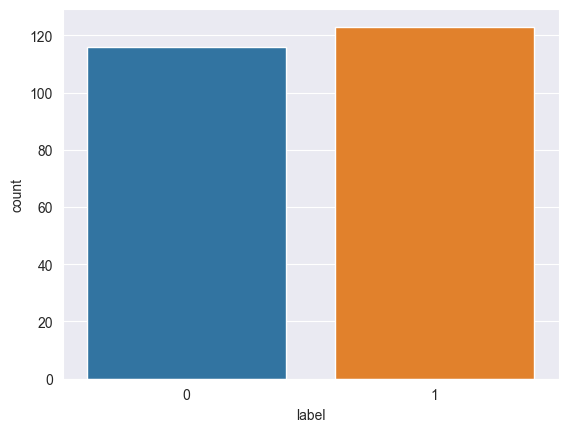

In [55]:
sns.countplot(datasets['train'].to_pandas(), x='label')

<Axes: xlabel='label', ylabel='count'>

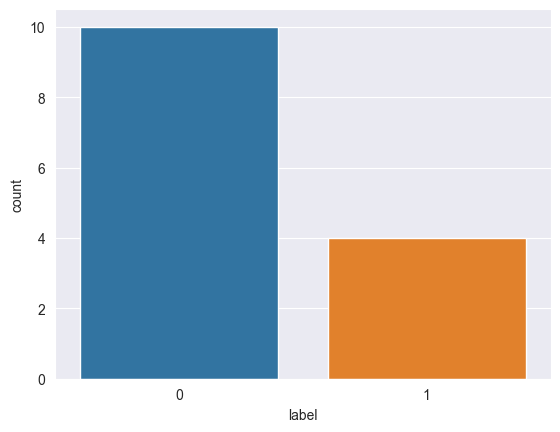

In [56]:
sns.countplot(datasets['test'].to_pandas(), x='label')

<Axes: xlabel='label', ylabel='count'>

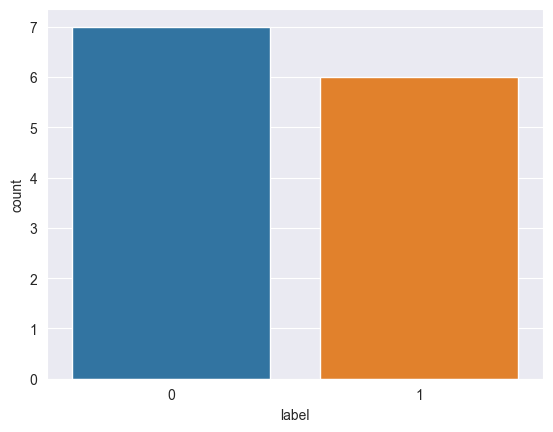

In [57]:
sns.countplot(datasets['valid'].to_pandas(), x='label')

#### Train

In [10]:
id2label = {0: 'irrelevant', 1: 'relevant'}
label2id = {'irrelevant': 0, 'relevant': 1}

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = AutoModelForSequenceClassification.from_pretrained(PRETRAINED_MODEL, num_labels=2, id2label=id2label, label2id=label2id)
model.to(device)


training_arguments = TrainingArguments(
    output_dir='m-messer/JavaDoc_Code_Relevance_Classifier',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=100,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=5,
    push_to_hub=False,
    report_to=["wandb"]
)

trainer = Trainer(
    model=model,
    args=training_arguments,
    train_dataset=datasets["train"],
    eval_dataset=datasets["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/marcus/workspace/Programming/JavaDoc_Code_Similarity/venv/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 14.29 GB, other allocations: 3.93 GB, max allowed: 18.13 GB). Tried to allocate 24.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

### Evaluation

In [ ]:
model.eval()

evaluator = evaluate.evaluator('text-classification')

eval_results = evaluator.compute(
    model_or_pipeline=model,
    data=datasets['test'],
    label_mapping=label2id
)

print(eval_results)